**Import** **Libraries**

In [10]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

import tensorflow as tf
import random as rn
import cv2
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

# New Section

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os
import cv2
import numpy as np

lookup = dict()
reverselookup = dict()
count = 0

# Populate lookup dictionaries for directory listing
for j in os.listdir('/content/drive/MyDrive/leapGestRecog/leapGestRecog/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1

x_data = []
y_data = []  # This will be a list of labels corresponding to x_data
IMG_SIZE = 150
datacount = 0

# Loop through directories and images
for i in range(0, 10):
    for j in os.listdir(f'/content/drive/MyDrive/leapGestRecog/leapGestRecog/0{i}/'):
        if not j.startswith('.'):
            count = 0
            # Loop through images within the current gesture directory
            for k in os.listdir(f'/content/drive/MyDrive/leapGestRecog/leapGestRecog/0{i}/{j}/'):
                path = f'/content/drive/MyDrive/leapGestRecog/leapGestRecog/0{i}/{j}/{k}'
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1

            # Append labels to y_data
            y_values = np.full((count, 1), lookup[j])
            y_data.extend(y_values)  # Extend y_data with labels for current gesture
            datacount = datacount + count

# Convert x_data and y_data to numpy arrays
x_data = np.array(x_data, dtype='float32')
y_data = np.array(y_data)

# Reshape y_data to match the number of samples
y_data = y_data.reshape(datacount, 1)


**Define Gesture Labels And Prepare** **Dataset**

In [22]:
for i in range(10):  # Loop over the ten top-level folders
    folder_path = f'C:/Users/ADMIN/Desktop/leapGestRecog/0{i}/'
    total_files = sum([len(files) for _, _, files in os.walk(folder_path)])
    print(f"Total files in {folder_path}: {total_files}")

Total files in C:/Users/ADMIN/Desktop/leapGestRecog/00/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/01/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/02/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/03/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/04/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/05/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/06/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/07/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/08/: 0
Total files in C:/Users/ADMIN/Desktop/leapGestRecog/09/: 0


**Visualize random samples from the dataset**

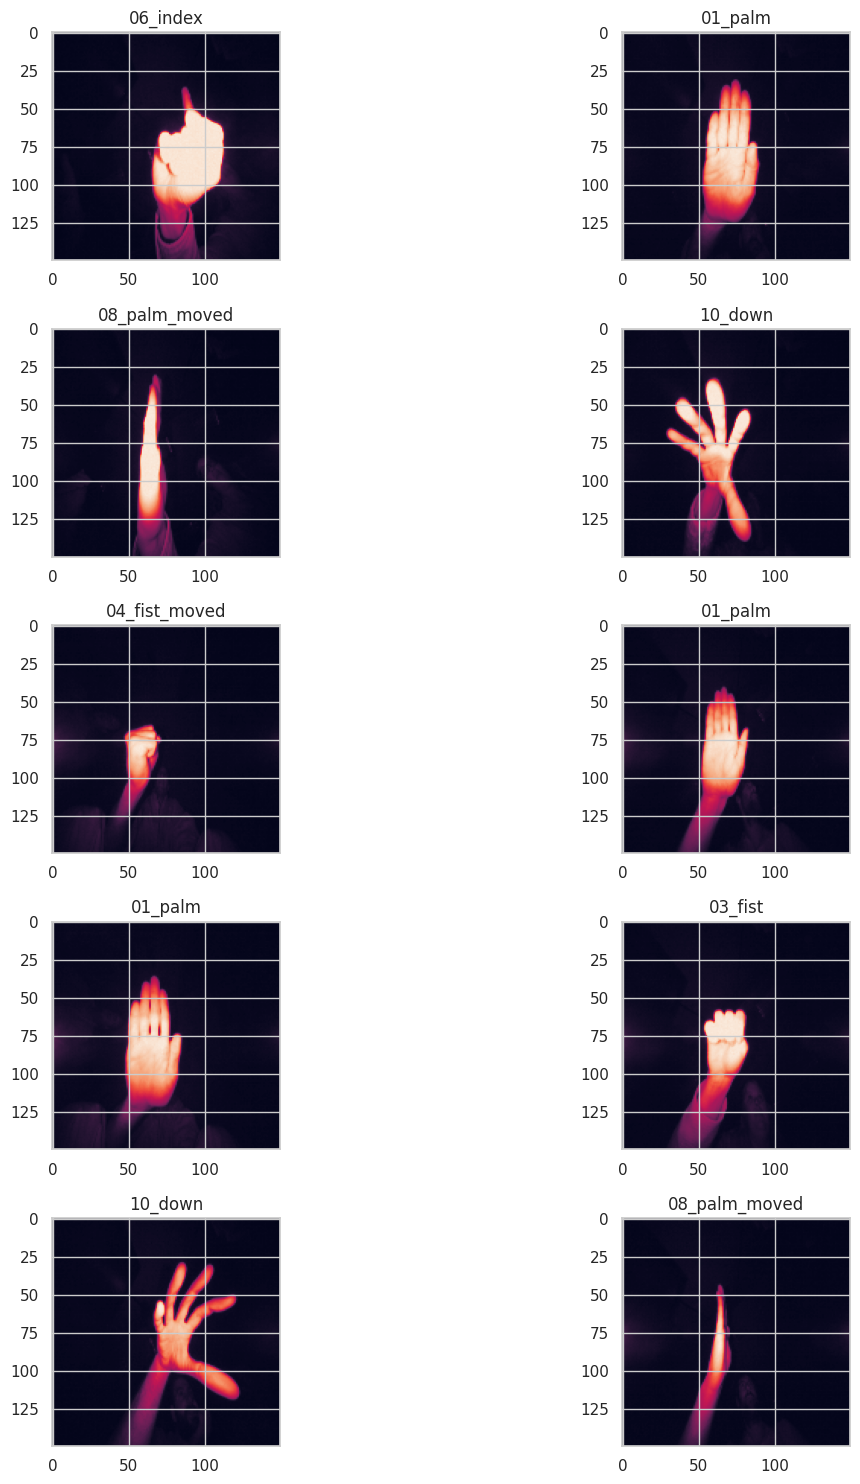

In [23]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(2):
        l = rn.randint(0, len(y_data))
        ax[i, j].imshow(x_data[l])
        ax[i, j].set_title(reverselookup[y_data[l, 0]])

plt.tight_layout()

**Preprocess the data and split into training and testing sets**

In [24]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255


In [ ]:
# #shuffle data
# type(x_data)
# np.random.shuffle(x_data)
# np.random.shuffle(y_data)

In [25]:
type(x_data)

numpy.ndarray

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.20,random_state=0)

**Build the CNN Model**

In [27]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

**Set Up Training Parameters And Callbacks**

In [30]:
batch_size=32
epochs=2

In [31]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

**Compile The Model And Display Model Summary**

In [32]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

**Train the model¶**

In [34]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/2
501/501 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9494
Epoch 1: val_loss improved from inf to 0.00988, saving model to ./base.model
501/501 [==============================] - 972s 2s/step - loss: 0.1572 - accuracy: 0.9494 - val_loss: 0.0099 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 2/2
501/501 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994
Epoch 2: val_loss improved from 0.00988 to 0.00379, saving model to ./base.model
501/501 [==============================] - 972s 2s/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9993 - lr: 0.0010


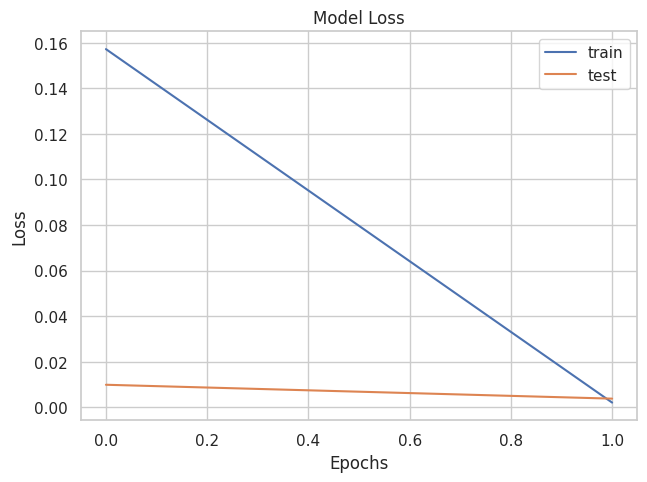

In [35]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

**Training and Validation Graph**

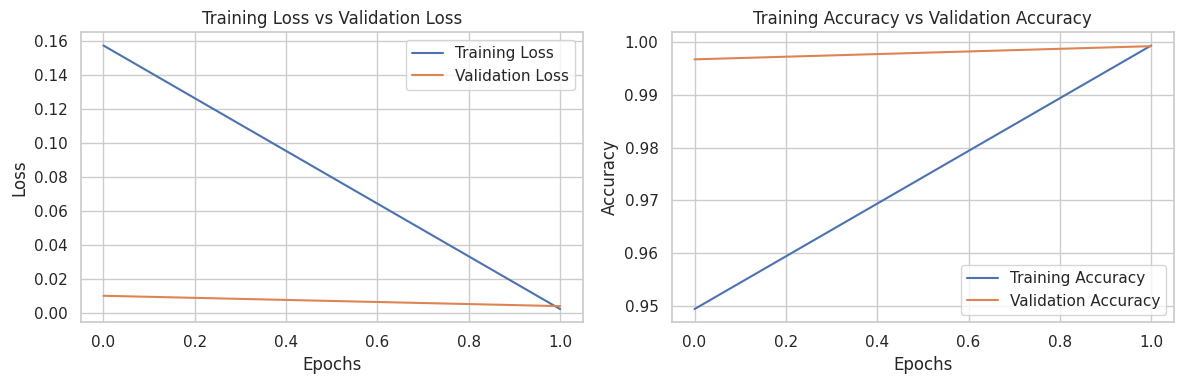

In [36]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(History.history['accuracy'], label='Training Accuracy')
plt.plot(History.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Confidence Score**

1/1 [==============================] - 1s 810ms/step


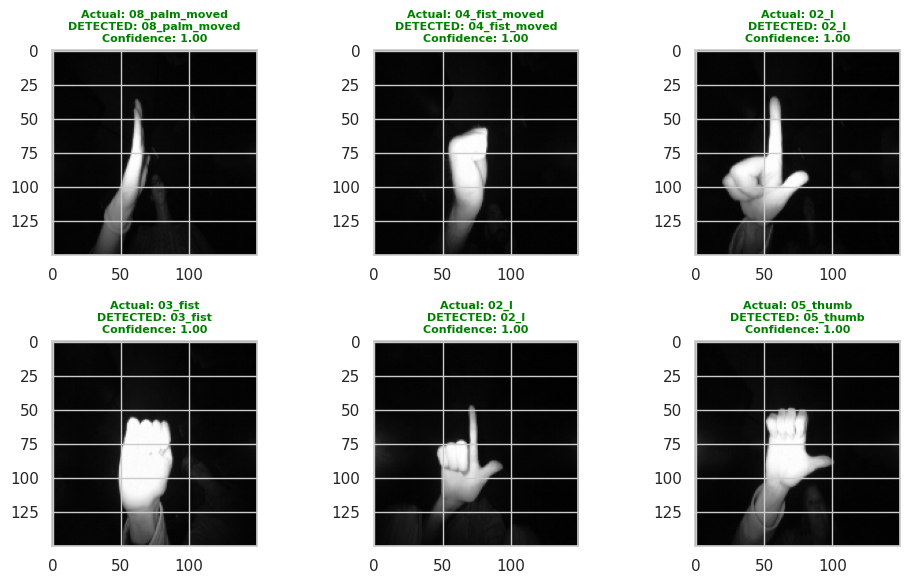

In [37]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Assuming you have a function to reverse lookup the class indices
def reverse_lookup(index):
    return reverselookup[index]

# Select random samples from the test set
num_samples_to_visualize = 6
random_indices = random.sample(range(len(x_test)), num_samples_to_visualize)
x_random_samples = x_test[random_indices]
y_random_labels = y_test[random_indices]  # Assuming y_test contains the true labels

# Make predictions on the randomly selected test samples
predictions_random = model.predict(x_random_samples)

# Visualize predictions for the randomly selected test samples in 2 rows
num_rows = 2
num_cols = num_samples_to_visualize // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        # Plot the original image
        axes[i, j].imshow(x_random_samples[index].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')

        # Print the confidence score in bold black color
        predicted_class = np.argmax(predictions_random[index])
        actual_class = np.argmax(y_random_labels[index])
        confidence = predictions_random[index][predicted_class]

        title_color = 'green' if predicted_class == actual_class else 'red'
        axes[i, j].set_title(f'Actual: {reverse_lookup(actual_class)}\nDETECTED: {reverse_lookup(predicted_class)}\nConfidence: {confidence:.2f}', color=title_color, backgroundcolor='white', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

**Confusion Matrix**

126/126 [==============================] - 77s 604ms/step


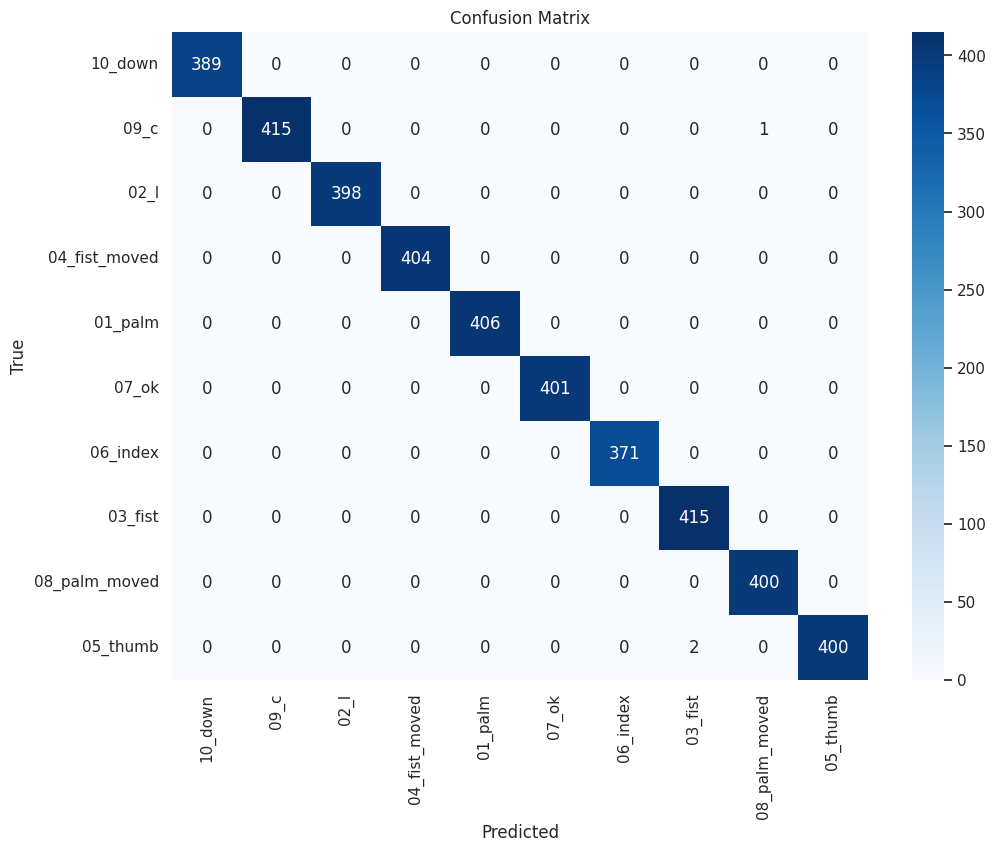

In [38]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
